# <span style='color:#0099CC'> Assignment: Advanced Regression

## Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know the following things about the prospective properties:

- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

### Importing required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### <span style='color:#0099CC'>Read the Data:

In [2]:
house_price_df_unaltered = pd.read_csv('train.csv')
house_price_df_unaltered.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Inspecting the dataframe

In [3]:
#Checking the shape
house_price_df_unaltered.shape

(1460, 81)

To view the summary of the dataframe `house_price_df_unaltered`

In [4]:
house_price_df_unaltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

To keep the original data frame unaltered the data frame a copy of `house_price_prediction_df_unaltered` is assigned to `house_price_prediction_df`.

In [5]:
house_price_df = house_price_df_unaltered.copy()

### To know the null values percentage in each attribute

In [6]:
# Creating a series with percentage of null values
null_values_series = round(house_price_df.isnull().sum()/len(house_price_df) * 100,2)


In [7]:
#Converting to a dataframe
null_values_df = pd.DataFrame({'columns':null_values_series.index, 'Null Value Percentage':null_values_series.values})


In [8]:
# Diplaying top 20 attributes with null values
null_values_df.sort_values(ascending=False, by='Null Value Percentage').head(20)

,columns,Null Value Percentage
72,PoolQC,99.52
74,MiscFeature,96.30
6,Alley,93.77
73,Fence,80.75
57,FireplaceQu,47.26
3,LotFrontage,17.74
59,GarageYrBlt,5.55
64,GarageCond,5.55
58,GarageType,5.55
60,GarageFinish,5.55


In [9]:
# Total number of missing values
house_price_df.isnull().sum().sum()

6965

### <span style='color:#0099cc'>Replacing the missing values with appropriate values

From the data definition , the missing values are replaced with appropriate values:
- Missing values in `Alley` column is **No alley access**
- Missing values in `GarageType` and `GarageFinish` is **No Garage**, but these missing values are replaced with **-1** to maintain the uniformity when labelencoding is done on other **Garage** related columns.
- Missing values in `MiscFeature` is **None**.

In [10]:
house_price_df['Alley'].fillna('No alley access',inplace=True)
house_price_df[['GarageType','GarageFinish']].fillna(-1,inplace=True)
house_price_df['MiscFeature'].fillna('None',inplace=True)

Replacing the missing values in Categorical values with **'-1'** value, which will be later used to encode the ordinal categorical values.

In [11]:
replace_na_with_minus = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
                         'GarageQual','GarageCond','PoolQC','Fence']
for i in replace_na_with_minus:
    house_price_df[i].fillna('-1',inplace=True)

### <span style='color:#0099cc'> Label Encoding the Ordinal Categorical columns

To reduce the number of columns while creating the dummies for the dataset, all the ordinal categorical variables are label encoded.

In [12]:
ordinal_columns = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu',
                   'GarageQual','GarageCond','PoolQC']
encode_dict = {'Ex': 4,
             'Gd': 3,
             'TA': 2,
             'Fa': 1,
             'Po': 0,
             '-1':-1}
for i in ordinal_columns:
    house_price_df[i] = house_price_df[i].map(encode_dict)
    print(house_price_df[i].value_counts())

2    906
3    488
4     52
1     14
Name: ExterQual, dtype: int64
2    1282
3     146
1      28
4       3
0       1
Name: ExterCond, dtype: int64
 2    649
 3    618
 4    121
-1     37
 1     35
Name: BsmtQual, dtype: int64
 2    1311
 3      65
 1      45
-1      37
 0       2
Name: BsmtCond, dtype: int64
4    741
2    428
3    241
1     49
0      1
Name: HeatingQC, dtype: int64
2    735
3    586
4    100
1     39
Name: KitchenQual, dtype: int64
-1    690
 3    380
 2    313
 1     33
 4     24
 0     20
Name: FireplaceQu, dtype: int64
 2    1311
-1      81
 1      48
 3      14
 0       3
 4       3
Name: GarageQual, dtype: int64
 2    1326
-1      81
 1      35
 3       9
 0       7
 4       2
Name: GarageCond, dtype: int64
-1    1453
 3       3
 4       2
 1       2
Name: PoolQC, dtype: int64


In [13]:
exposure_dict = {'Gd':3,
                 'Av':2,
                 'Mn':1,
                 'No':0,
                 '-1':-1}
house_price_df['BsmtExposure'] = house_price_df['BsmtExposure'].map(exposure_dict) 
house_price_df['BsmtExposure'].value_counts()

 0    953
 2    221
 3    134
 1    114
-1     38
Name: BsmtExposure, dtype: int64

In [14]:
finType_columns = ['BsmtFinType1','BsmtFinType2']
finType_dict = {'GLQ':5,
                 'ALQ':4,
                 'BLQ':3,
                 'Rec':2,
                 'LwQ':1,
                 'Unf':0,
                 '-1':-1}
for i in finType_columns:
    house_price_df[i] = house_price_df[i].map(finType_dict)
    print(house_price_df[i].value_counts())

 0    430
 5    418
 4    220
 3    148
 2    133
 1     74
-1     37
Name: BsmtFinType1, dtype: int64
 0    1256
 2      54
 1      46
-1      38
 3      33
 4      19
 5      14
Name: BsmtFinType2, dtype: int64


In [15]:
fence_dict = {'GdPrv':5,
              'MnPrv':4,
              'GdWo':3,
              'MnWw':2,
              '-1':-1}
house_price_df['Fence'] = house_price_df['Fence'].map(fence_dict)
house_price_df['Fence'].value_counts()

-1    1179
 4     157
 5      59
 3      54
 2      11
Name: Fence, dtype: int64

In [16]:
house_price_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [17]:
house_price_df['LotFrontage']

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1460, dtype: float64

### Dropping the columns with missing value greater than 35%

In [18]:
for i in house_price_df.columns:
    missing_per = house_price_df[i].isnull().sum() / len(house_price_df) * 100.00
    if(missing_per > 35):
        print(i,":",missing_per)
        house_price_df.drop(i,axis=1,inplace=True)

From the output it is clear that, None of the columns have missing values greater than 35%.

### <span style='color:#0099cc'> Imputing Null Values

#### Imputing in Categorical columns

In [19]:
# Creating a list which contains all the categorical variables
categorical_columns = []
for i in house_price_df.columns:
    if house_price_df[i].dtype == 'O':
        categorical_columns.append(i)

In [20]:
for i in categorical_columns:
    if(house_price_df[i].isnull().sum()>0):
        print("======================================")
        print(i,":",house_price_df[i].isnull().sum() / len(house_price_df) * 100.00)
        print(house_price_df[i].value_counts())


MasVnrType : 0.547945205479452
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
Electrical : 0.0684931506849315
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
GarageType : 5.5479452054794525
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
GarageFinish : 5.5479452054794525
Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64


Replacing missing values in Categorical columns with mode.

In [21]:
for i in categorical_columns:
    house_price_df[i].fillna(house_price_df[i].mode()[0], inplace=True)
    

#### Imputing in Numerical columns

In [22]:
# The missing values in the numeric columns are replaced with the respective mean
for i in house_price_df.columns:
    #
    if(house_price_df[i].dtype != 'O' and house_price_df[i].isnull().sum()>0):
        house_price_df[i].fillna(house_price_df[i].mean(),inplace=True)

To confirm whether all the missing values are replaced

In [23]:
house_price_df.isnull().sum().sum()

0

### <span style='color:#0099cc'>Dropping the skewed categorical columns

The categorical columns which have a value with frequency of greater than 96%(arbitrary) are removed.

In [24]:
print("The columns which are skewed: One of the value if more than 96% ")
count = 0
for i in categorical_columns:
    if house_price_df[i].value_counts()[0]/len(house_price_df) * 100 > 96:
        house_price_df.drop(i,axis=1,inplace=True)
        categorical_columns.remove(i)
        print(i)

The columns which are skewed: One of the value if more than 96% 
Street
Utilities
Condition2
RoofMatl
Heating
MiscFeature


### <span style='color:#0099cc'>Dropping the numerical columns if the `value_counts` of a individual value is greater than 96%

In [25]:
count = 0
print("The numeric columns where a individual value frequency is greater than 96% are: ")
for i in house_price_df.columns:
    if house_price_df[i].dtype != 'O':
        if(house_price_df[i].value_counts().values[0] > 0.96*len(house_price_df)):
            print(i)
            house_price_df.drop(i,axis=1,inplace=True)

The numeric columns where a individual value frequency is greater than 96% are: 
LowQualFinSF
3SsnPorch
PoolArea
PoolQC
MiscVal


### <span style='color:#0099cc'>Checking the value counts for each categorical columns

In [26]:
count = 0
for i in house_price_df.columns:
    if house_price_df[i].dtype == 'O':
        count+=1
        print(round(house_price_df[i].value_counts()/len(house_price_df)*100,2))
        

RL         78.84
RM         14.93
FV          4.45
RH          1.10
C (all)     0.68
Name: MSZoning, dtype: float64
No alley access    93.77
Grvl                3.42
Pave                2.81
Name: Alley, dtype: float64
Reg    63.36
IR1    33.15
IR2     2.81
IR3     0.68
Name: LotShape, dtype: float64
Lvl    89.79
Bnk     4.32
HLS     3.42
Low     2.47
Name: LandContour, dtype: float64
Inside     72.05
Corner     18.01
CulDSac     6.44
FR2         3.22
FR3         0.27
Name: LotConfig, dtype: float64
Gtl    94.66
Mod     4.45
Sev     0.89
Name: LandSlope, dtype: float64
NAmes      15.41
CollgCr    10.27
OldTown     7.74
Edwards     6.85
Somerst     5.89
Gilbert     5.41
NridgHt     5.27
Sawyer      5.07
NWAmes      5.00
SawyerW     4.04
BrkSide     3.97
Crawfor     3.49
Mitchel     3.36
NoRidge     2.81
Timber      2.60
IDOTRR      2.53
ClearCr     1.92
SWISU       1.71
StoneBr     1.71
Blmngtn     1.16
MeadowV     1.16
BrDale      1.10
Veenker     0.75
NPkVill     0.62
Blueste     0.14

### <span style='color:#0099cc'>Changing the categorical column values to Others if it's percentage is <= 1

In [27]:
for i in categorical_columns:
    # Assigning the value as index and value counts to a series
    value_count_series = round(house_price_df[i].value_counts() / len(house_price_df) * 100,2)
    if len(value_count_series) > 3:
        # Setting a threshold of 1% , the below line will return the boolean array
        threshold = value_count_series <= 1.0
        # Getting the index of the value_counts less than or equal to 1%
        index_of_replacement_values = value_count_series[threshold].index
        if(len(index_of_replacement_values)>0):
            # Creating a dictionary which is less than 1% and replacing it with value 'Others'
            replacement_dict = dict.fromkeys(index_of_replacement_values, 'Others')
            # Updating the data frame: Replacing the values in the df which are in the 
            #dictionary replacement_dict with dict value Others
            #ex : house_price_df['LotShape'] = house_price_df['LotShape'].replace('IR3','Others') 
            house_price_df[i] = house_price_df[i].replace(replacement_dict) 
            print("======================")
            print(house_price_df[i].value_counts())

RL        1151
RM         218
FV          65
RH          16
Others      10
Name: MSZoning, dtype: int64
Reg       925
IR1       484
IR2        41
Others     10
Name: LotShape, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
Others        4
Name: LotConfig, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Others      22
Blmngtn     17
MeadowV     17
BrDale      16
Name: Neighborhood, dtype: int64
Norm      1260
Feedr       81
Artery      48
RRAn        26
Others      26
PosN        19
Name: Condition1, dtype: int64
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
Others     33
Name: HouseStyle, dtype: int64
Gable     1141
Hip        286
Others      33
Name: RoofStyle, dtype: int64
VinylSd    5

### <span style='color:#0099cc'>Dropping the ID column

As the ID columns are redundant in model prediction , it is dropped

In [28]:
house_price_df.drop('Id',axis=1,inplace=True)

### <span style='color:#0099cc'>Checking if the target variable is normally distributed

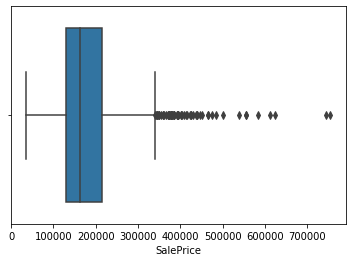

In [29]:
sns.boxplot(house_price_df['SalePrice'])
plt.show()

From the above output it is clear that there are outliers present in the target variable. If we handle outliers by capping or dropping,we will be limiting the data or loose the data respectively. Hence we need tranform the target variable.

### <span style='color:#0099cc'> Log Tranformation of the Target variable

In [30]:
house_price_df['SalePrice'] = np.log(house_price_df['SalePrice'])

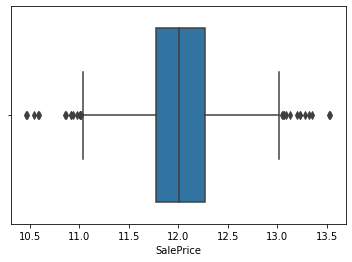

In [31]:
sns.boxplot(house_price_df['SalePrice'])
plt.show()

### <span style='color:#0099cc'> Handling Year columns

We have the `YearBuilt` attribute from which the age of the house(`AgeOfHouse`) is found and the redundant `YearBuilt` column is dropped.

In [32]:
import datetime
present_year = datetime.date.today().year

In [33]:
house_price_df['AgeOfHouse'] = present_year - house_price_df['YearBuilt']
house_price_df.drop('YearBuilt',axis=1,inplace=True)

Dropping the other redundant year columns from the dataset.

In [34]:
house_price_df.drop(['YearRemodAdd','GarageYrBlt','YrSold'],axis=1,inplace=True)

In [35]:
house_price_df.shape

(1460, 66)

## <span style='color:#0099cc'>Data Preparation

### <span style='color:#0099CC'> Splitting the predictor and dependent variables

In [36]:
y = house_price_df['SalePrice']
house_price_df.drop('SalePrice',axis=1,inplace=True)
X = house_price_df

In [37]:
# creating dummy variables for categorical variables

# subset all categorical variables
house_categorical = X.select_dtypes(include=['object'])
house_categorical.head()

,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,MasVnrType,Foundation,CentralAir,Electrical,Functional,GarageType,GarageFinish,PavedDrive,SaleType,SaleCondition
0,RL,No alley access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,...,BrkFace,PConc,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
1,RL,No alley access,Reg,Lvl,FR2,Gtl,Others,Feedr,1Fam,1Story,...,None,CBlock,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
2,RL,No alley access,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,...,BrkFace,PConc,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
3,RL,No alley access,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,...,None,BrkTil,Y,SBrkr,Typ,Detchd,Unf,Y,WD,Abnorml
4,RL,No alley access,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,...,BrkFace,PConc,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal


In [38]:
# convert into dummies - one hot encoding
encoded_house_categorical = pd.get_dummies(house_categorical, drop_first=True)
encoded_house_categorical.head()

,MSZoning_Others,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_No alley access,Alley_Pave,LotShape_IR2,LotShape_Others,LotShape_Reg,LandContour_HLS,...,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,SaleType_New,SaleType_Others,SaleType_WD,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
1,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3,0,0,1,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


In [39]:
# drop categorical variables 
X = X.drop(list(house_categorical.columns), axis=1)

In [40]:
# concat dummy variables with X
X = pd.concat([X, encoded_house_categorical], axis=1)

## <span style='color:#0099cc'> Scaling the varibles

Ridge regression regularize the linear regression by imposing a penalty on the size of coefficients. Thus the coefficients are shrunk toward zero and toward each other. But when this happens and if the independent variables does not have the same scale, the shrinking is not fair. Two independent variables with different scales will have different contributions to the penalized terms, because the penalized term is a sum of squares of all the coefficients. To avoid such kind of problems, very often, the independent variables are centered and scaled in order to have variance 1.

In [41]:
cols = X.columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [42]:
 # Converting the arrays to a dataframe
X = pd.DataFrame(X)
X.columns = cols
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,SaleType_New,SaleType_Others,SaleType_WD,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Others,SaleCondition_Partial
0,0.235294,0.150685,0.033420,0.666667,0.500,0.12250,0.666667,0.5,0.8,0.75,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.00000,0.333333,0.5,0.8,0.75,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.10125,0.666667,0.5,0.8,0.75,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.00000,0.333333,0.5,0.6,1.00,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.21875,0.666667,0.5,0.8,0.75,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [43]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)


In [44]:
X_train.shape

(1021, 148)

# <span style='color:#0099cc'> Model Building

- Ridge regularisation doesn't make any of the variables to 0.
- As there is a limitaion of Lasso Regularisation on how much variables it can penalise to 0.
<br/>To avoid the above limitations, before using Regularisation top 50 variables are selected using RFE(Recursive Feature Elimination)

### <span style='color:#0099cc'>RFE (Recursive Feature Elimination)

Since the data set as 148 columns we cannot follow the manual approach to select the variables. Hence we need to use RFE to select top 50 variables.

In [45]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [46]:
# Fit the linear regression model on the trained data set
lm = LinearRegression()
lm.fit(X_train,y_train)

# Running RFE with the 50 variables
rfe = RFE(lm,50)
rfe = rfe.fit(X_train,y_train)

Among the 149 columns , using the RFE method, the top 50 variables are selected.

In [47]:
col_selected_RFE  = X_train.columns[rfe.support_]
col_selected_RFE

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'TotalBsmtSF',
       'HeatingQC', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'FireplaceQu', 'GarageCars', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'ScreenPorch', 'AgeOfHouse', 'MSZoning_Others',
       'MSZoning_RH', 'LotShape_Others', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_MeadowV',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_Norm', 'Condition1_RRAn',
       'BldgType_Twnhs', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd',
       'Exterior2nd_CmentBd', 'Functional_Mod', 'Functional_Others',
       'SaleType_New', 'SaleType_Others', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object')

In [48]:
# The X_train is updated with RFE selected columns
X_train_RFE = X_train[col_selected_RFE]

In [49]:
X_train_RFE.shape

(1021, 50)

In [50]:
# The X_test is updated with RFE selected columns
X_test_RFE = X_test[col_selected_RFE]

In [51]:
X_test_RFE.shape

(438, 50)

### <span style='color:#0099cc'>Linear Regression

Let's try with linear regression to predict the sale price.

In [52]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train_RFE, y_train)

LinearRegression()

In [53]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

10.785895993365362
[-0.12747849 -0.12366311  0.42277115  0.4415929   0.34125112  0.10035417
  0.07721123  0.07279867 -0.07198085 -0.03741847  0.07879287  0.31031342
  0.92976586  0.17263346  0.1229899   0.0668788   0.11617492 -0.10666064
  0.05529828  0.11750927  0.07499265  0.23404198  0.20872124 -0.20267761
  0.07647248  0.12092473 -0.32317509 -0.36561575  0.04561338 -0.13960794
  0.12410779  0.15842179 -0.0736617  -0.11245621  0.10905441  0.13853254
  0.10444079  0.15391616  0.07305126  0.07785029 -0.09381185  0.09820378
 -0.11449115  0.10278465 -0.09114648 -0.10387001  0.03565331  0.09054115
  0.05060895  0.03565331]


In [54]:
from sklearn.metrics import r2_score, mean_squared_error

In [55]:
# Prediction on the Train data set
y_pred_train = lm.predict(X_train_RFE)

# Prediction on the Test data set
y_pred_test = lm.predict(X_test_RFE)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score train data set :"+str(r2_train_lr))
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score test data set :"+str(r2_test_lr))
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS score train data set:",rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS score test data set:",rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE score train data set:",mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RSS score test data set:",mse_test_lr)
metric.append(mse_test_lr**0.5)


r2_score train data set :0.9062882814267897
r2_score test data set :0.8972159265922696
RSS score train data set: 15.040003843544277
RSS score test data set: 7.407501296090404
MSE score train data set: 0.01473065998388274
RSS score test data set: 0.016912103415731516


In [56]:
betas = pd.DataFrame(index=X_train_RFE.columns)

In [57]:
betas.rows = X.columns

In [58]:
betas['Linear'] = lm.coef_
betas['Linear'].sort_values(ascending=False)[0:5]

GrLivArea      0.929766
OverallQual    0.441593
LotArea        0.422771
OverallCond    0.341251
1stFlrSF       0.310313
Name: Linear, dtype: float64

In [59]:
betas['Linear'].sort_values(ascending=False)[-5:]

MSSubClass        -0.127478
LotShape_Others   -0.139608
GarageCond        -0.202678
AgeOfHouse        -0.323175
MSZoning_Others   -0.365616
Name: Linear, dtype: float64

From the above 2 outputs it is clear that the top 5 most important predictor variable is 
- `GrLivArea`
- `OverallQual`
- `LotArea`
- `OverallCond`
- `1stFlrSF`

### <span style='color:#0099cc'>Ridge Regression

To avoid the overfitting issue , the data set is fitted with Ridge Regression

In [60]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [61]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_RFE, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.9s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [62]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [63]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised
alpha = 0.0001
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_RFE, y_train)
print(ridge.coef_)

[-0.12747536 -0.12364929  0.4227474   0.44159653  0.34124824  0.10035244
  0.07721166  0.0727978  -0.07197125 -0.03739983  0.0787933   0.31031776
  0.92970007  0.17263184  0.12299999  0.06688473  0.11617434 -0.10666382
  0.05530098  0.11752866  0.07499413  0.23404192  0.20869687 -0.20265049
  0.07647418  0.12092306 -0.32316682 -0.36560967  0.04561449 -0.13960466
  0.12410989  0.15842152 -0.07366102 -0.11245407  0.10905759  0.13853058
  0.10444029  0.15391532  0.07305024  0.0778495  -0.09381157  0.09820305
 -0.11447867  0.10277217 -0.09114436 -0.10386771  0.03565335  0.09054085
  0.05060916  0.03565335]


In [64]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train_RFE)
y_pred_test = ridge.predict(X_test_RFE)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score train data set :"+str(r2_train_lr))
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score test data set :"+str(r2_test_lr))
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS score train data set:",rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS score test data set:",rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE score train data set:",mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RSS score test data set:",mse_test_lr)
metric2.append(mse_test_lr**0.5)

r2_score train data set :0.9062882813717921
r2_score test data set :0.8972163445639448
RSS score train data set: 15.04000385237097
RSS score test data set: 7.40747117346903
MSE score train data set: 0.014730659992527885
RSS score test data set: 0.016912034642623357


In [65]:
betas['Ridge'] = ridge.coef_
betas['Ridge'].sort_values(ascending=False)[0:5]

GrLivArea      0.929700
OverallQual    0.441597
LotArea        0.422747
OverallCond    0.341248
1stFlrSF       0.310318
Name: Ridge, dtype: float64

In [66]:
betas['Ridge'].sort_values(ascending=False)[-5:]

MSSubClass        -0.127475
LotShape_Others   -0.139605
GarageCond        -0.202650
AgeOfHouse        -0.323167
MSZoning_Others   -0.365610
Name: Ridge, dtype: float64

From the above 2 outputs it is clear that the top 5 most important predictor variable is 
- `GrLivArea`
- `OverallQual`
- `LotArea`
- `OverallCond`
- `1stFlrSF`

### <span style='color:#0099cc'>Lasso Regression

In Ridge regression the variable elimination is not available, hence to reduce the model complexity, Lasso Regression is used.

In [67]:
from sklearn.linear_model import Lasso

In [68]:
lasso = Lasso()
params = {'alpha': [0.0001, 0.001,0.003,0.004, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_RFE, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.9s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.003, 0.004, 0.01, 0.05, 0.1,
                                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                                   2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                   20, 50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [69]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [70]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_RFE, y_train) 

Lasso(alpha=0.0001)

In [71]:
lasso.coef_

array([-0.12599136, -0.08242777,  0.36296532,  0.45714736,  0.33629472,
        0.09563547,  0.07870096,  0.06872514, -0.02121685,  0.        ,
        0.07813188,  0.25607298,  0.90667187,  0.16060731,  0.12728751,
        0.06337946,  0.10025586, -0.07454355,  0.0586249 ,  0.12664058,
        0.07978552,  0.23273927,  0.07220654, -0.06022275,  0.07445323,
        0.11200991, -0.31946563, -0.35301685,  0.03766942, -0.13084931,
        0.12218803,  0.1540308 , -0.0709653 , -0.0958233 ,  0.10567389,
        0.13173498,  0.10104907,  0.14553479,  0.07055993,  0.07056379,
       -0.09049472,  0.09541766, -0.01379155,  0.        , -0.07446936,
       -0.0949933 ,  0.02798651,  0.08470277,  0.04984276,  0.04100319])

In [72]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train_RFE)
y_pred_test = lasso.predict(X_test_RFE)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score train data set :"+str(r2_train_lr))
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score test data set :"+str(r2_test_lr))
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS score train data set:",rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS score test data set:",rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE score train data set:",mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RSS score test data set:",mse_test_lr)
metric3.append(mse_test_lr**0.5)

r2_score train data set :0.905726789861639
r2_score test data set :0.8984201983156268
RSS score train data set: 15.130118883867517
RSS score test data set: 7.3207111538450444
MSE score train data set: 0.01481892153170178
RSS score test data set: 0.016713952406038915


To infer which are the important predictor variables

In [73]:
betas['Lasso'] = lasso.coef_
betas['Lasso'].sort_values(ascending=False)[0:5]

GrLivArea      0.906672
OverallQual    0.457147
LotArea        0.362965
OverallCond    0.336295
1stFlrSF       0.256073
Name: Lasso, dtype: float64

In [74]:
betas['Lasso'].sort_values(ascending=False)[-5:]

Neighborhood_MeadowV   -0.095823
MSSubClass             -0.125991
LotShape_Others        -0.130849
AgeOfHouse             -0.319466
MSZoning_Others        -0.353017
Name: Lasso, dtype: float64

From the above 2 outputs it is clear that the top 5 most important predictor variable is 
- `GrLivArea`
- `OverallQual`
- `LotArea`
- `OverallCond`
- `1stFlrSF`

In [75]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.906288,0.906288,0.905727
1,R2 Score (Test),0.897216,0.897216,0.898420
2,RSS (Train),15.040004,15.040004,15.130119
3,RSS (Test),7.407501,7.407471,7.320711
4,MSE (Train),0.121370,0.121370,0.121733
5,MSE (Test),0.130047,0.130046,0.129282


## Question 1:

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

### <span style='color:blue'> Ridge Regression:<br/>
If we double the value of alpha

In [76]:
#Fitting Ridge model for alpha = 0.0001 * 2 and printing coefficients which have been penalised
alpha = 0.0001*2
ridge_alpha_double = Ridge(alpha=alpha)

ridge_alpha_double.fit(X_train_RFE, y_train)
print(ridge_alpha_double.coef_)

[-0.12747224 -0.12363548  0.42272365  0.44160017  0.34124537  0.10035071
  0.0772121   0.07279693 -0.07196166 -0.0373812   0.07879374  0.3103221
  0.92963428  0.17263023  0.12301008  0.06689066  0.11617376 -0.10666699
  0.05530368  0.11754805  0.07499562  0.23404186  0.20867252 -0.20262337
  0.07647589  0.12092139 -0.32315855 -0.36560359  0.0456156  -0.13960138
  0.12411198  0.15842124 -0.07366033 -0.11245193  0.10906077  0.13852863
  0.10443979  0.15391449  0.07304923  0.07784871 -0.0938113   0.09820233
 -0.11446619  0.1027597  -0.09114223 -0.10386541  0.03565339  0.09054056
  0.05060936  0.03565339]


In [77]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge_alpha_double.predict(X_train_RFE)
y_pred_test = ridge_alpha_double.predict(X_test_RFE)

metric4 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score train data set :"+str(r2_train_lr))
metric4.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score test data set :"+str(r2_test_lr))
metric4.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS score train data set:",rss1_lr)
metric4.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS score test data set:",rss2_lr)
metric4.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE score train data set:",mse_train_lr)
metric4.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RSS score test data set:",mse_test_lr)
metric4.append(mse_test_lr**0.5)

r2_score train data set :0.9062882812068386
r2_score test data set :0.897216762337809
RSS score train data set: 15.040003878844736
RSS score test data set: 7.407441065103619
MSE score train data set: 0.014730660018457136
RSS score test data set: 0.016911965902063057


In [78]:
betas['ridge_alpha_double'] = ridge_alpha_double.coef_
betas['ridge_alpha_double'].sort_values(ascending=False)[0:5]

GrLivArea      0.929634
OverallQual    0.441600
LotArea        0.422724
OverallCond    0.341245
1stFlrSF       0.310322
Name: ridge_alpha_double, dtype: float64

In [79]:
betas['ridge_alpha_double'].sort_values(ascending=False)[-5:]

MSSubClass        -0.127472
LotShape_Others   -0.139601
GarageCond        -0.202623
AgeOfHouse        -0.323159
MSZoning_Others   -0.365604
Name: ridge_alpha_double, dtype: float64

The important variable is `GrLivArea`

### <span style='color:blue'> Lasso Regression:<br/>

If we double the value of alpha

In [80]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001 * 2

lasso_alpha_2 = Lasso(alpha=alpha)
        
lasso_alpha_2.fit(X_train_RFE, y_train) 

Lasso(alpha=0.0002)

In [81]:
lasso_alpha_2.coef_

array([-0.12585165, -0.03927431,  0.30400697,  0.47077466,  0.33095192,
        0.0962153 ,  0.07912844,  0.06838348, -0.        ,  0.        ,
        0.0784831 ,  0.23205951,  0.8892305 ,  0.15484848,  0.12913587,
        0.06260873,  0.08828621, -0.0433556 ,  0.06022421,  0.12693989,
        0.08364489,  0.23206668,  0.01448541, -0.        ,  0.07475544,
        0.10254353, -0.31413888, -0.34073245,  0.02931235, -0.11699344,
        0.12068456,  0.15006394, -0.06905313, -0.08573159,  0.10279383,
        0.12665764,  0.09764868,  0.1358054 ,  0.06889305,  0.06342246,
       -0.08677885,  0.09270332, -0.0105513 , -0.        , -0.05965962,
       -0.08630115,  0.0322886 ,  0.07816449,  0.04834229,  0.03418245])

In [82]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso_alpha_2.predict(X_train_RFE)
y_pred_test = lasso_alpha_2.predict(X_test_RFE)

metric5 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("r2_score train data set :"+str(r2_train_lr))
metric5.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("r2_score test data set :"+str(r2_test_lr))
metric5.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS score train data set:",rss1_lr)
metric5.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS score test data set:",rss2_lr)
metric5.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE score train data set:",mse_train_lr)
metric5.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RSS score test data set:",mse_test_lr)
metric5.append(mse_test_lr**0.5)

r2_score train data set :0.9049109458826916
r2_score test data set :0.898385571843867
RSS score train data set: 15.261055513415247
RSS score test data set: 7.323206634184908
MSE score train data set: 0.014947165047419438
RSS score test data set: 0.01671964984973723


In [83]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')
rg_metric_2 = pd.Series(metric4, name = 'Ridge Regression alpha * 2')
lg_metric_2 = pd.Series(metric4, name = 'Lasso Regression alpha * 2')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric,rg_metric_2,lg_metric_2], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression,Ridge Regression alpha * 2,Lasso Regression alpha * 2
0,R2 Score (Train),0.906288,0.906288,0.905727,0.906288,0.906288
1,R2 Score (Test),0.897216,0.897216,0.898420,0.897217,0.897217
2,RSS (Train),15.040004,15.040004,15.130119,15.040004,15.040004
3,RSS (Test),7.407501,7.407471,7.320711,7.407441,7.407441
4,MSE (Train),0.121370,0.121370,0.121733,0.121370,0.121370
5,MSE (Test),0.130047,0.130046,0.129282,0.130046,0.130046


In [84]:
betas['lasso_alpha_2'] = lasso_alpha_2.coef_
betas['lasso_alpha_2'].sort_values(ascending=False)[0:5]

GrLivArea      0.889230
OverallQual    0.470775
OverallCond    0.330952
LotArea        0.304007
GarageCars     0.232067
Name: lasso_alpha_2, dtype: float64

In [85]:
betas['lasso_alpha_2'].sort_values(ascending=False)[-5:]

BldgType_Twnhs    -0.086779
LotShape_Others   -0.116993
MSSubClass        -0.125852
AgeOfHouse        -0.314139
MSZoning_Others   -0.340732
Name: lasso_alpha_2, dtype: float64

The most important variable is `Functional_Others`

# Question 2

You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

 

### <span style='color:blue'>The optimal value of lambda for ridge and lasso are 0.05 and 0.0001 respectively. The value of lambda 0.05 is choosen because as the value of lambda is low, then the shrinkage penalty will decrease and it itends towards zero. This will not overcome the **Overfitting** issue.

# Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [86]:
betas['lasso_alpha_2'].sort_values(ascending=False)[0:5]

GrLivArea      0.889230
OverallQual    0.470775
OverallCond    0.330952
LotArea        0.304007
GarageCars     0.232067
Name: lasso_alpha_2, dtype: float64

In [87]:
X_train_RFE.drop(['GrLivArea','OverallQual','OverallCond','LotArea','1stFlrSF'], axis=1, inplace=True)

In [88]:
lasso_quest_3 = Lasso()
params = {'alpha': [0.0001, 0.001,0.003,0.004, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
# cross validation
model_cv = GridSearchCV(estimator = lasso_quest_3, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_RFE, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.003, 0.004, 0.01, 0.05, 0.1,
                                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                                   2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                   20, 50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [89]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [90]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso_quest_3 = Lasso(alpha=alpha)
        
lasso_quest_3.fit(X_train_RFE, y_train) 

Lasso(alpha=0.0001)

In [91]:
lasso_quest_3.coef_

array([-0.09150336,  0.00851584,  0.08926227,  0.11641461,  0.06277308,
        0.07642026,  0.57733037,  0.11059206,  0.1326914 ,  0.32073321,
        0.14040488,  0.04387942, -0.32663671,  0.19693879,  0.57856031,
        0.11890616,  0.24977232,  0.19310963, -0.10437115,  0.12839281,
        0.1202895 , -0.1625468 , -0.44814126,  0.06265183, -0.11720986,
        0.12586512,  0.1902999 , -0.09191131, -0.17128568,  0.18826873,
        0.13224898,  0.11032796,  0.19149555,  0.05373962,  0.06929763,
       -0.08512187,  0.1041845 , -0.        ,  0.00711021, -0.09439678,
       -0.12907193,  0.02452634,  0.0815721 ,  0.05439377,  0.04224086])

In [92]:
betas_2 = pd.DataFrame(index=X_train_RFE.columns)
betas_2['lasso_quest_3'] = lasso_quest_3.coef_
betas_2['lasso_quest_3'].sort_values(ascending=False)[0:5]

TotRmsAbvGrd    0.578560
TotalBsmtSF     0.577330
FullBath        0.320733
GarageCars      0.249772
KitchenQual     0.196939
Name: lasso_quest_3, dtype: float64

In [93]:
betas_2['lasso_quest_3'].sort_values(ascending=False)[-5:]

Functional_Others      -0.129072
AgeOfHouse             -0.162547
Neighborhood_MeadowV   -0.171286
KitchenAbvGr           -0.326637
MSZoning_Others        -0.448141
Name: lasso_quest_3, dtype: float64